In [28]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')
from mpl_toolkits.mplot3d import Axes3D

from data.synthetic_dataset import create_synthetic_dataset, SyntheticDataset, SyntheticDatasetMultivariate
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from torch.utils.data import DataLoader
from tslearn.metrics import dtw, dtw_path

# from loss.dilate_loss import dilate_loss
from loss.sDTW import SoftDTW

import sys
sys.path.append('../')
sys.path.append('../src')
from utils.tools import brownian, Lorenz
from src.sigKer_torch import SigLoss, SigLoss_naive
from src.sigKerHom_torch import SigLossHom

In [2]:
def rcos(t):
#     a = np.random.uniform(1,1.2)
    a = 0.5
    return t*np.cos(a*t)
def rsin(t):
#     b = np.random.uniform(1,1.2)
    b = 0.5
    return t*np.sin(b*t)

def generate_curve(N, L=100, T=5*np.pi):
    t = np.linspace(0,T,L)[:,None]
    return 1/T*np.array([np.concatenate([t,rcos(t),rsin(t)], axis=1) for k in range(N)])

In [22]:
dtype = torch.float64
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU
a  = 1.5
b = -2.4
T_y = 100
T_x = 100

y = torch.tensor(generate_curve(1,T_y,10*np.pi), device=device, dtype=dtype, requires_grad=False)

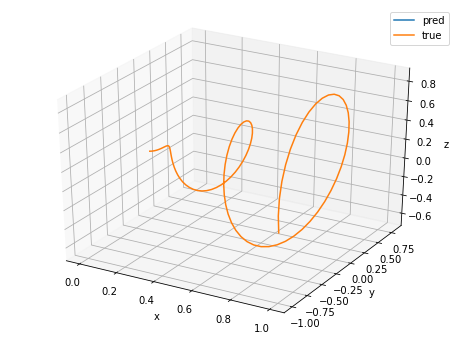

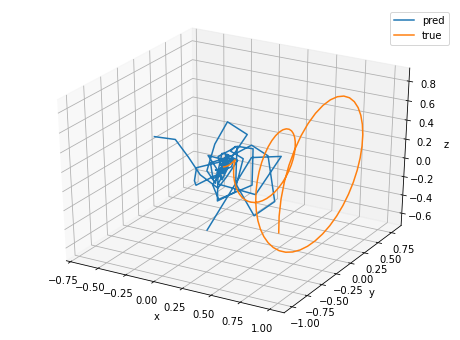

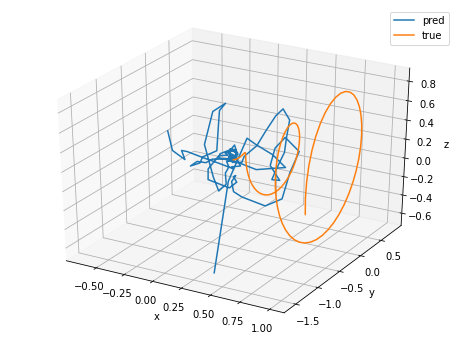

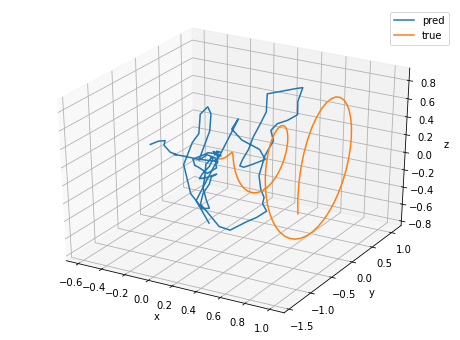

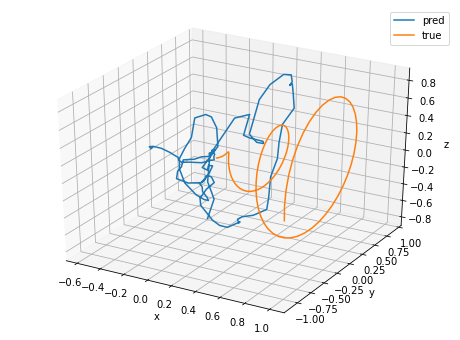

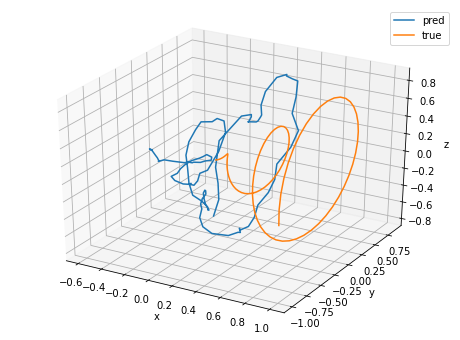

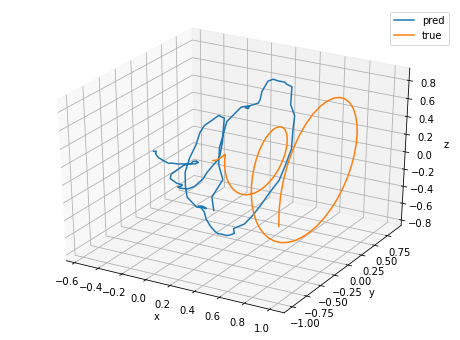

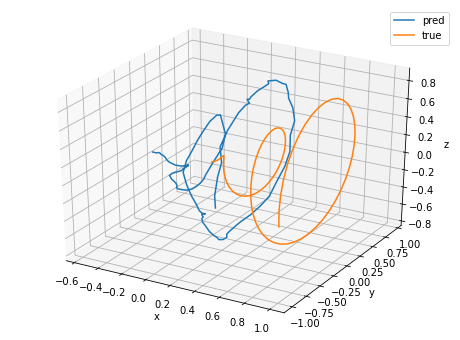

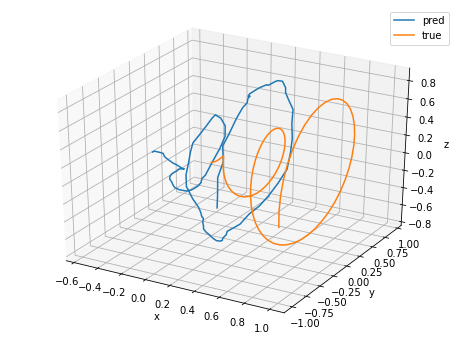

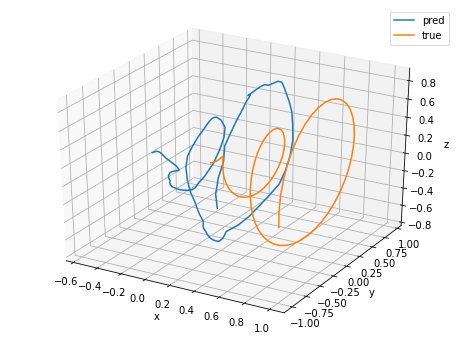

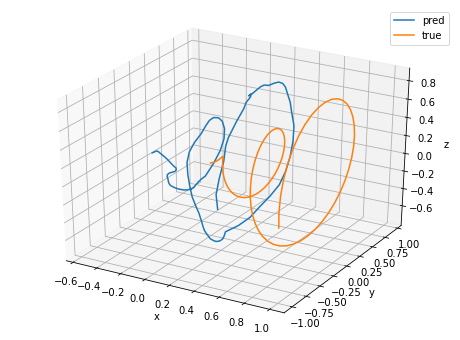

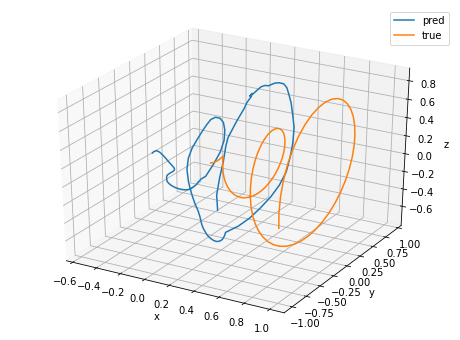

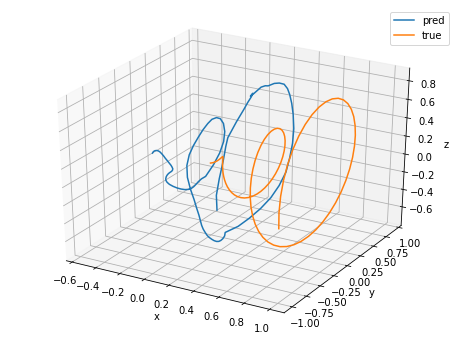

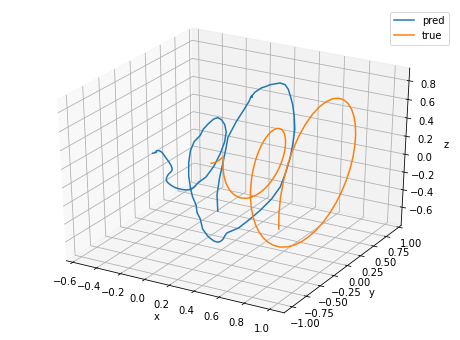

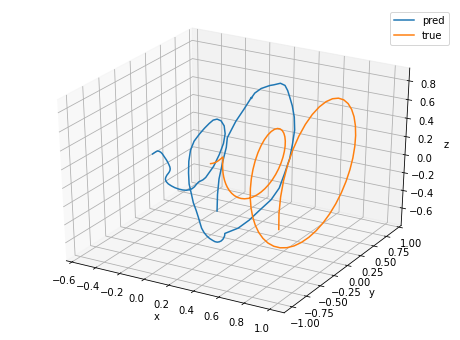

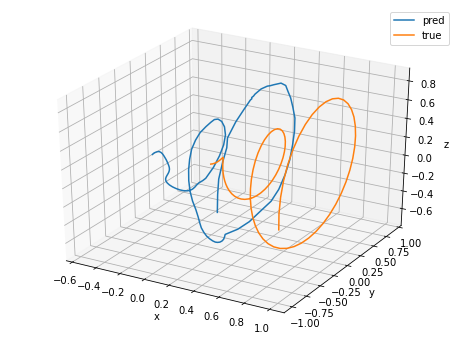

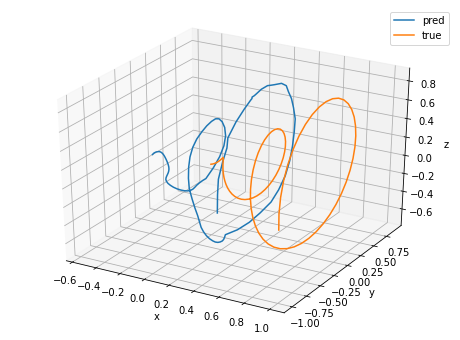

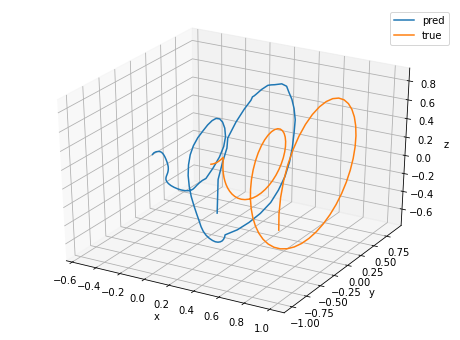

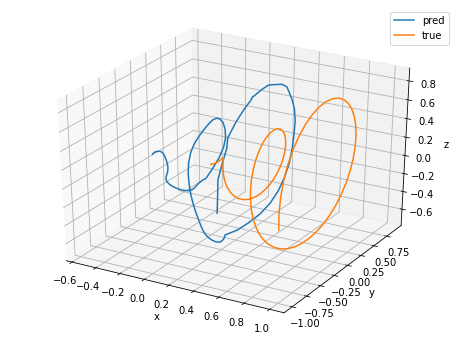

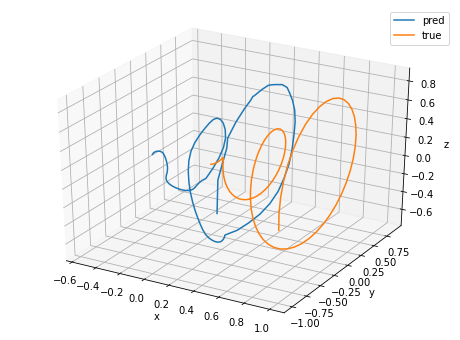

In [31]:
learning_rate = 1e-1

x = torch.tensor(np.zeros((1,T_x,3)), device=device, dtype=dtype,requires_grad=True)

optimizer = torch.optim.Adam([x], lr=learning_rate)

losses = []

e = 1
for t in range(200):

#     criterion = torch.nn.MSELoss()
#     criterion = SoftDTW(gamma=0.001, normalize=True)
    criterion = SigLoss(n=0, n_chunks=3)
    loss = criterion(x,y)    
    
    if t % 10 == 0:
#         plt.plot(y.detach().numpy()[0,:,0], y.detach().numpy()[0,:,1], label='true')
#         plt.plot(x.detach().numpy()[0,:,0], x.detach().numpy()[0,:,1], label='pred')
#         plt.legend()
#         plt.show()
        fig = plt.figure(figsize=(8,6))
        ax = fig.gca(projection='3d')
        ax.plot(x.detach().numpy()[0,:,0],x.detach().numpy()[0,:,1],x.detach().numpy()[0,:,2], label='pred')
        ax.plot(y.detach().numpy()[0,:,0],y.detach().numpy()[0,:,1],y.detach().numpy()[0,:,2], label='true')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.legend()
        plt.savefig(f'fig{e}.png')
        plt.show()
        e+=1

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

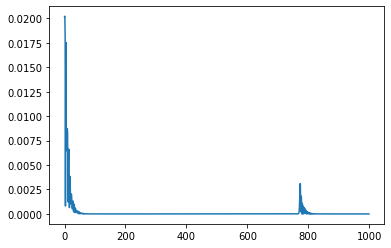

In [13]:
plt.plot(losses)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(0)

In [35]:
# parameters
batch_size = 5
N = 50 # number of time series
N_input = 50 # number of input time steps
N_output = 50  # number of time steps to predict
gamma = 0.01

In [37]:
# X_train = 0.2*np.array(Lorenz(N, N_input+N_output))
# X_test = 0.2*np.array(Lorenz(N, N_input+N_output))
X_train = generate_curve(N, N_input+N_output)
X_test = generate_curve(N, N_input+N_output)

In [38]:
x = X_train[0]

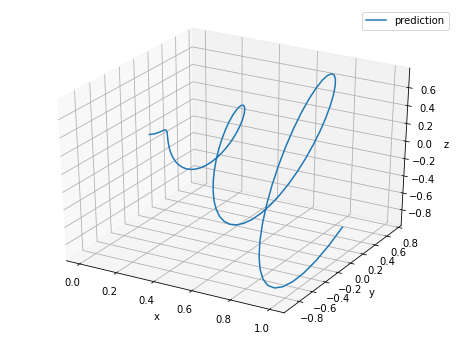

In [39]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.plot(x[:,0],x[:,1],x[:,2], label='prediction')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend()
plt.show()

In [7]:
X_train_input = torch.tensor(X_train[:,:N_input,:], dtype=torch.float64)
X_train_target = torch.tensor(X_train[:,N_input:,:], dtype=torch.float64)
X_test_input = torch.tensor(X_test[:,:N_input,:], dtype=torch.float64)
X_test_target = torch.tensor(X_test[:,N_input:,:], dtype=torch.float64)

In [8]:
# Make datasets
# dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
# dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
dataset_train = SyntheticDatasetMultivariate(X_train_input, X_train_target)
dataset_test  = SyntheticDatasetMultivariate(X_test_input, X_test_target)
trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

In [17]:
def train_model(net, loss_type, learning_rate, epochs=1000, print_every=50, eval_every=50, 
                gamma=0.001, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):

            inputs, target = data
            inputs = torch.tensor(inputs, dtype=torch.float64).to(device)
            target = torch.tensor(target, dtype=torch.float64).to(device)
            batch_size, N_output = target.shape[0:2]                     

            outputs = net(inputs)
            
            if loss_type=='mse':
                criterion = torch.nn.MSELoss()
                loss = criterion(target,outputs)
            
            elif loss_type=='soft-dtw':
                criterion = SoftDTW(gamma=gamma, normalize=True)
                loss = criterion(target,outputs).mean()
                
            elif loss_type=='signature':
                criterion = SigLoss(n=1, n_chunks=1)
                loss = criterion(target,outputs).mean()
                
            else:    
                loss, loss_shape, loss_temporal = dilate_loss(target, outputs, alpha, gamma, device)             
                  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          

        if (epoch % print_every == 0):
            print('epoch=', epoch, ' loss type=', loss_type, ' loss=', np.round(loss.item(),4))
        if (epoch % eval_every == 0):
            eval_model(net, testloader, gamma)

In [18]:
def eval_model(net, loader, gamma):   
        
    losses_mse = []

    for i, data in enumerate(loader, 0):
        
        loss_mse = torch.tensor(0,dtype=torch.float64)
        
        inputs, target = data
        inputs = torch.tensor(inputs, dtype=torch.float64).to(device)
        target = torch.tensor(target, dtype=torch.float64).to(device)
        batch_size, N_output = target.shape[0:2]
        
        outputs = net(inputs)
         
        # MSE    
        loss_mse = torch.nn.MSELoss()(target,outputs)    
        losses_mse.append(loss_mse.item())

    k = 0
    x = outputs.detach().cpu().numpy()[k]
    y = target.detach().cpu().numpy()[k]
    fig = plt.figure(figsize=(8,6))
    ax = fig.gca(projection='3d')
    ax.plot(x[:,0],x[:,1],x[:,2], label='prediction')
    ax.plot(y[:,0],y[:,1],y[:,2], label='target')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.legend()
    plt.show()
        
    print('test-mse=', np.round(np.array(losses_mse).mean(),4)) 

epoch= 0  loss type= mse  loss= 0.2074


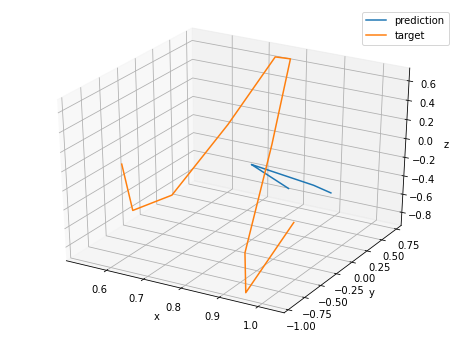

test-mse= 0.2007
epoch= 5  loss type= mse  loss= 0.1703


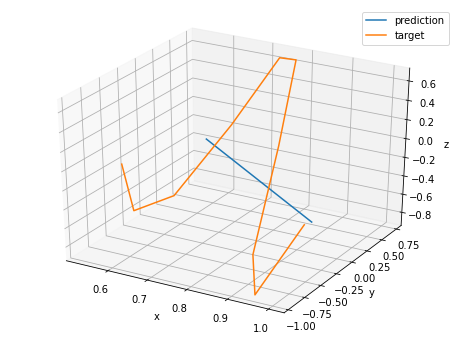

test-mse= 0.1811
epoch= 10  loss type= mse  loss= 0.2092


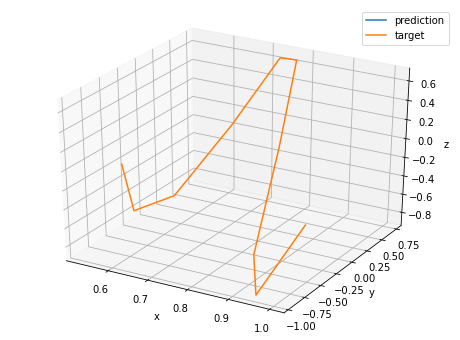

test-mse= 0.2035
epoch= 15  loss type= mse  loss= 0.2051


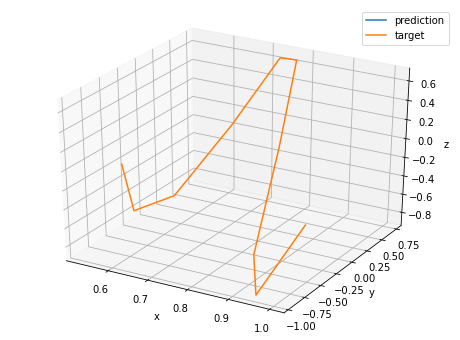

test-mse= 0.2034
epoch= 20  loss type= mse  loss= 0.2071


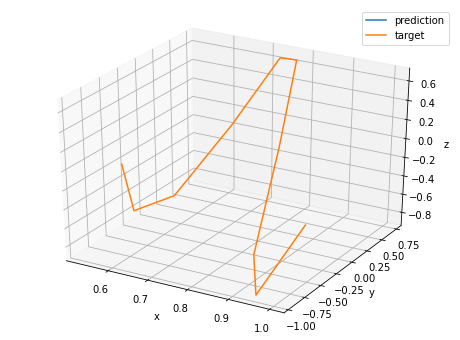

test-mse= 0.2036
epoch= 25  loss type= mse  loss= 0.2091


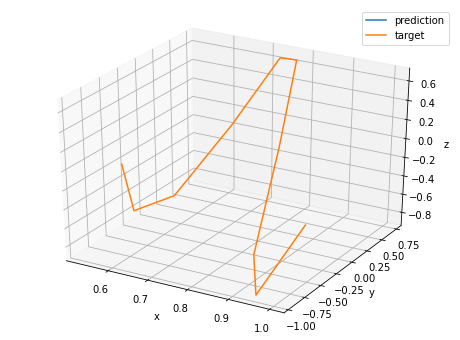

test-mse= 0.2033


KeyboardInterrupt: 

In [24]:
encoder = EncoderRNN(input_size=3, hidden_size=4, num_grulstm_layers=1, batch_size=batch_size).double().to(device)
decoder = DecoderRNN(input_size=3, hidden_size=4, num_grulstm_layers=1, fc_units=4, output_size=3).double().to(device)
net_gru_mse = Net_GRU(encoder, decoder, N_output, device).double().to(device)
train_model(net_gru_mse, loss_type='mse', learning_rate=0.1, epochs=100, print_every=5, eval_every=5)

epoch= 0  loss type= soft-dtw  loss= 6.6493


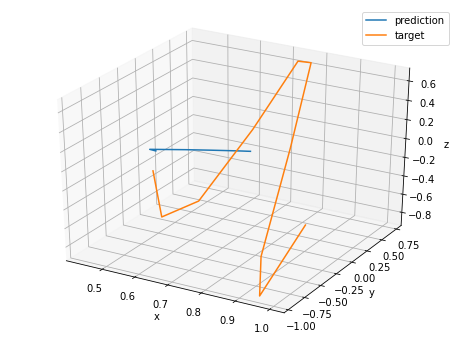

test-mse= 0.2136
epoch= 10  loss type= soft-dtw  loss= 4.0963


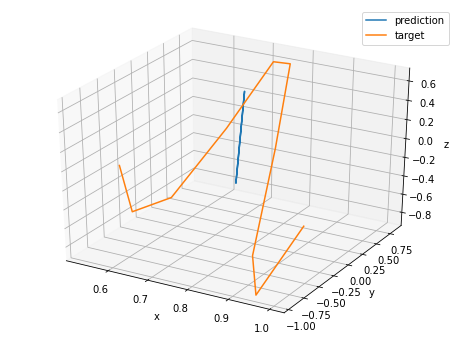

test-mse= 0.2934


KeyboardInterrupt: 

In [25]:
encoder = EncoderRNN(input_size=3, hidden_size=4, num_grulstm_layers=1, batch_size=batch_size).double().to(device)
decoder = DecoderRNN(input_size=3, hidden_size=4, num_grulstm_layers=1, fc_units=4, output_size=3).double().to(device)
net_gru_sdtw = Net_GRU(encoder, decoder, N_output, device).double().to(device)
train_model(net_gru_sdtw, loss_type='soft-dtw', learning_rate=0.1, epochs=100, print_every=10, eval_every=10)

epoch= 0  loss type= signature  loss= 31.6208


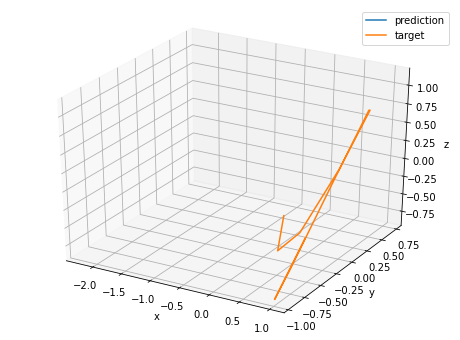

test-mse= 3.7494
epoch= 5  loss type= signature  loss= 18.6562


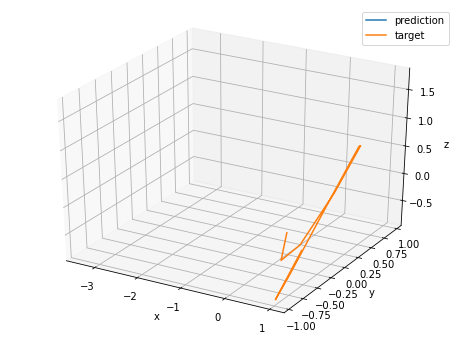

test-mse= 7.426
epoch= 10  loss type= signature  loss= 45.3182


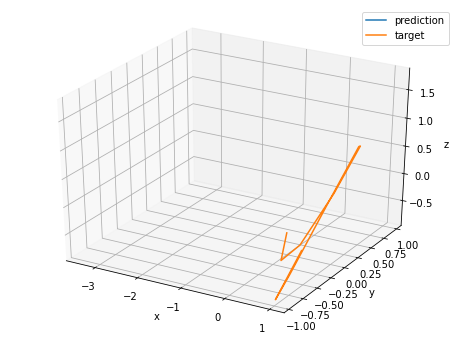

test-mse= 7.4632


KeyboardInterrupt: 

In [23]:
encoder = EncoderRNN(input_size=3, hidden_size=4, num_grulstm_layers=1, batch_size=batch_size).double().to(device)
decoder = DecoderRNN(input_size=3, hidden_size=4, num_grulstm_layers=1, fc_units=4, output_size=3).double().to(device)
net_gru_sig = Net_GRU(encoder, decoder, N_output, device).double().to(device)
train_model(net_gru_sig, loss_type='signature', learning_rate=0.5, epochs=50, print_every=5, eval_every=5)

In [199]:
# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float64).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float64).to(device)
criterion = torch.nn.MSELoss()

nets = [net_gru_mse, net_gru_sdtw, net_gru_sig]
titles = ['mse loss', 'soft-dtw loss', 'signature loss']

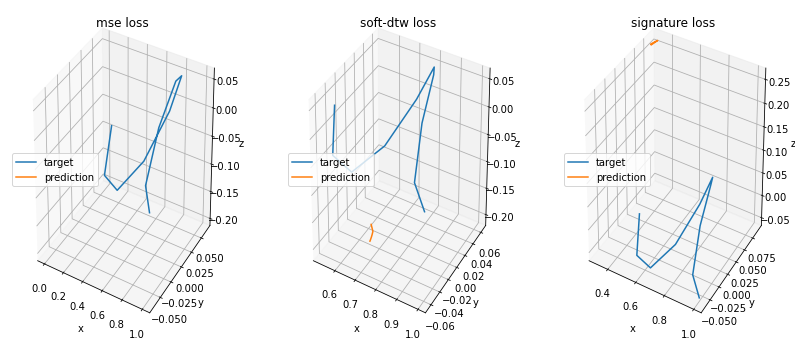

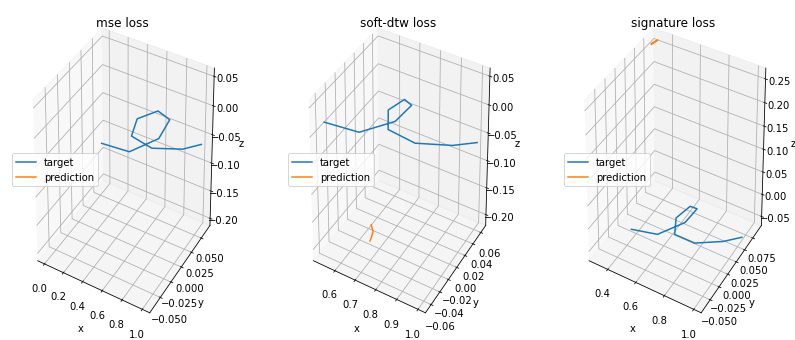

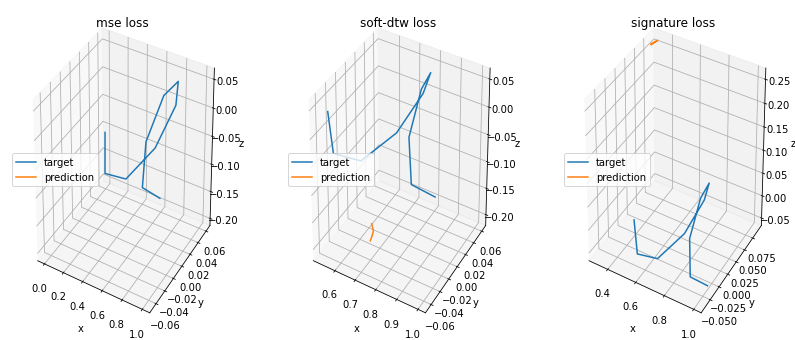

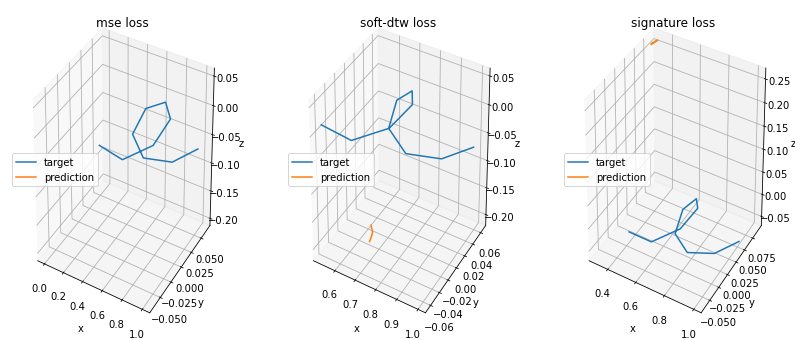

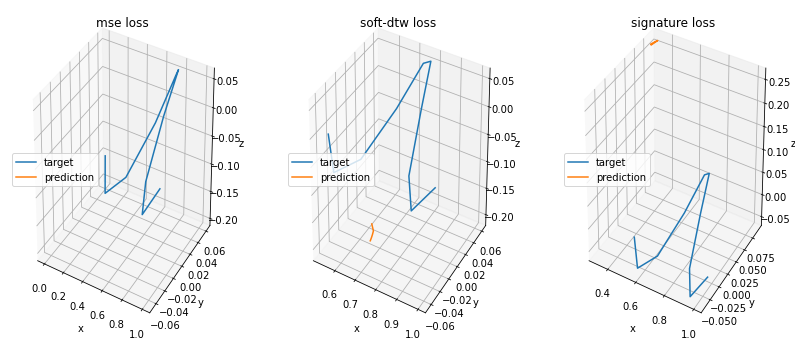

In [195]:
for ind in range(batch_size):
     
    k = 1
    fig = plt.figure(figsize=(14,6))
    
    for net in nets:
        
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]
        
        ax = fig.add_subplot(1, 3, k, projection='3d')
#         ax.plot(input[:,0],input[:,1],input[:,2], label='input')
        ax.plot(target[:,0],target[:,1],target[:,2], label='target')
        ax.plot(preds[:,0],preds[:,1],preds[:,2], label='prediction')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_title(titles[k-1])
        plt.legend(loc='center left')

#         plt.subplot(1,3,k)
#         plt.plot(range(0, N_input), input, label='input', linewidth=1)
#         plt.plot(range(N_input-1,N_input+N_output), np.concatenate([input[N_input-1:N_input], target ]),
#                  label='target',linewidth=3)   
#         plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ]),
#                  label='prediction',linewidth=3)       
#         plt.xticks(range(0,40,2))
#         plt.legend()
        k = k+1
    plt.show()